In [1]:
# to auto reload the modified module
% load_ext autoreload
% autoreload 2

In [2]:
import tensorflow as tf
import numpy as np
import random
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import gc

from utils import *
from data import MnistTF
from nn_kd import *
from layers import *
# from models import *

/home/deep3072/anaconda2/envs/tu36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [3]:
# session settings
session = create_session(gpu_id='1')
check_available_device()
# seed settings
set_rand_seed(0)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12739351585406497070
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4402380800
locality {
  bus_id: 1
}
incarnation: 14543437146194861376
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1"
]


In [4]:
# read Mnist data
try_cls2 = True
if try_cls2:
    mnist = MnistTF()
    X_train, y_train = mnist.get_train_data()
    X_val, y_val = mnist.get_validation_data()
    X_test, y_test = mnist.get_test_data()
    print_obj(X_train, 'X_train')
    print_obj(y_train, 'y_train')
    print_obj(X_val, 'X_val')
    print_obj(y_val, 'y_val')
    print_obj(X_test, 'X_test')
    print_obj(y_test, 'y_test')
    input_dims = X_train.shape[1]
    output_dims = y_train.shape[1]
    print_obj(input_dims, 'input_dims')
    print_obj(output_dims, 'output_dims')


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
X_train <class 'numpy.ndarray'> (55000, 784)
y_train <class 'numpy.ndarray'> (55000, 10)
X_val <class 'numpy.ndarray'> (5000, 784)
y_val <class 'numpy.ndarray'> (5000, 10)
X_test <class 'numpy.ndarray'> (10000, 784)
y_test <class 'numpy.ndarray'> (10000, 10)
input_dims <class 'int'> 784
output_dims <class 'int'> 10


In [5]:
def build_big_model(input_dims, output_dims, session):

    bigmodel = SoftenedNN(
        input_dims=input_dims
        , output_dims=output_dims
        , session=session
        , dtype_X=tf.float32
        , dtype_y=tf.float32)

#     bigmodel.add_layer(
#         Dropout(inputs=bigmodel.h[-1], keep_prob=0.8))
    bigmodel.add_layer(
        FC(inputs=bigmodel.h[-1],out_dims=1200, activation_fn=tf.nn.relu))
#     bigmodel.add_layer(
#         Dropout(inputs=bigmodel.h[-1], keep_prob=0.9))
    bigmodel.add_layer(
        FC(inputs=bigmodel.h[-1],out_dims=1200, activation_fn=tf.nn.relu))
#     bigmodel.add_layer(
#         Dropout(inputs=bigmodel.h[-1], keep_prob=0.9))
    bigmodel.add_layer(
        FC(inputs=bigmodel.h[-1],out_dims=output_dims, activation_fn=tf.nn.softmax))

    bigmodel.compile_nn(
        loss=tf.losses.softmax_cross_entropy(bigmodel.ys,bigmodel.logits)
        , opt=tf.train.AdamOptimizer(learning_rate=1e-3)
        , metrics = ['acc'])

    return bigmodel

In [6]:
if try_cls2:
    teacher = build_big_model(input_dims, output_dims, session)
    teacher.train(
        X=X_train
        ,y=y_train
        ,val_set=[X_val,y_val]
        ,batch_size=100
        ,n_epochs=50
        ,display_steps=100)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10730495653967716364
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4402380800
locality {
  bus_id: 1
}
incarnation: 7377397663281305081
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1"
]
Epoch 1 , step 0 , loss= 6.0402083 , acc = 0.33 
Epoch 1 , step 100 , loss= 0.15822172 , acc = 0.95 
Epoch 1 , step 200 , loss= 0.11774536 , acc = 0.97 
Epoch 1 , step 300 , loss= 0.080887645 , acc = 0.98 
Epoch 1 , step 400 , loss= 0.076720215 , acc = 0.99 
Epoch 1 , step 500 , loss= 0.0538679 , acc = 0.99 
Epoch 1 , step 549 , loss= 0.089837104 val_loss= 0.09999467 , acc = 0.95 val acc = 0.9696 
Epoch 1 finished, loss= 0.21704133 val loss= 0.09999467 ,  acc = 0.95210916 val acc = 0.9696

Epoch 2 , step 50 , loss= 0.014415246 , acc = 1.0 
Epoch 2 , step 150 , loss= 0.06124512 , acc = 0.98 
Epoch 2 , step 250 , loss= 0.031584784 , acc = 0.

Epoch 17 , step 500 , loss= 0.0006920118 , acc = 1.0 
Epoch 17 , step 549 , loss= 3.8418857e-05 val_loss= 0.09368787 , acc = 1.0 val acc = 0.9836 
Epoch 17 finished, loss= 0.0015877774 val loss= 0.09368787 ,  acc = 0.99969083 val acc = 0.9836

Epoch 18 , step 50 , loss= 0.0005536146 , acc = 1.0 
Epoch 18 , step 150 , loss= 0.00041944455 , acc = 1.0 
Epoch 18 , step 250 , loss= 0.000578051 , acc = 1.0 
Epoch 18 , step 350 , loss= 0.0018005862 , acc = 1.0 
Epoch 18 , step 450 , loss= 0.0067470735 , acc = 1.0 
Epoch 18 , step 549 , loss= 0.0014709099 val_loss= 0.105244115 , acc = 1.0 val acc = 0.981 
Epoch 18 finished, loss= 0.0014519845 val loss= 0.105244115 ,  acc = 0.99967265 val acc = 0.981

Epoch 19 , step 0 , loss= 0.00016177159 , acc = 1.0 
Epoch 19 , step 100 , loss= 0.0016352355 , acc = 1.0 
Epoch 19 , step 200 , loss= 5.241826e-06 , acc = 1.0 
Epoch 19 , step 300 , loss= 0.0029343993 , acc = 1.0 
Epoch 19 , step 400 , loss= 0.00036840304 , acc = 1.0 
Epoch 19 , step 500 , loss= 

Epoch 34 , step 450 , loss= 0.00063715735 , acc = 1.0 
Epoch 34 , step 549 , loss= 0.00031689904 val_loss= 0.12988783 , acc = 1.0 val acc = 0.9832 
Epoch 34 finished, loss= 0.0003372584 val loss= 0.12988783 ,  acc = 0.9999272 val acc = 0.9832

Epoch 35 , step 0 , loss= 0.00012641019 , acc = 1.0 
Epoch 35 , step 100 , loss= 1.5985155e-06 , acc = 1.0 
Epoch 35 , step 200 , loss= 4.0753024e-05 , acc = 1.0 
Epoch 35 , step 300 , loss= 2.3276465e-05 , acc = 1.0 
Epoch 35 , step 400 , loss= 0.0005510799 , acc = 1.0 
Epoch 35 , step 500 , loss= 0.0010181702 , acc = 1.0 
Epoch 35 , step 549 , loss= 9.867204e-06 val_loss= 0.16724692 , acc = 1.0 val acc = 0.983 
Epoch 35 finished, loss= 0.000750268 val loss= 0.16724692 ,  acc = 0.9998908 val acc = 0.983

Epoch 36 , step 50 , loss= 3.445497e-05 , acc = 1.0 
Epoch 36 , step 150 , loss= 0.00012253616 , acc = 1.0 
Epoch 36 , step 250 , loss= 1.9374169e-05 , acc = 1.0 
Epoch 36 , step 350 , loss= 6.1987294e-07 , acc = 1.0 
Epoch 36 , step 450 , loss=

Plotting loss...


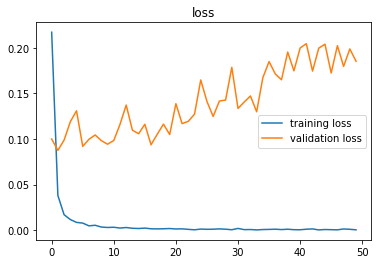

Plotting metrics...


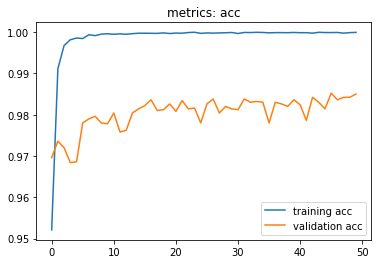

train {'acc': 0.9992}
test {'acc': 0.9846}


In [7]:
if try_cls2:
    teacher.plt_loss()
    teacher.plt_metrics()
    train_metric = teacher.get_metrics(X_train, y_train)
    test_metric = teacher.get_metrics(X_test, y_test)
    print('train',train_metric)
    print('test',test_metric)

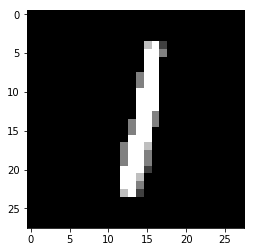

sample.max() 1.0
label [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
teacher.predict [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
teacher.predict_softened [[9.000e-04 9.807e-01 6.400e-03 1.000e-04 1.500e-03 3.000e-04 6.000e-04
  4.100e-03 4.900e-03 4.000e-04]]


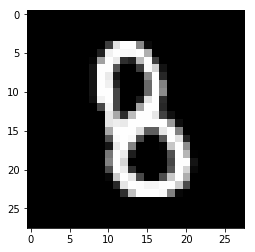

sample.max() 0.9960785
label [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
teacher.predict [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
teacher.predict_softened [[0.0055 0.0047 0.013  0.0055 0.0078 0.0197 0.0211 0.0043 0.9161 0.0024]]


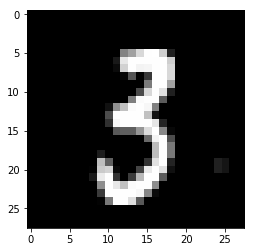

sample.max() 1.0
label [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
teacher.predict [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
teacher.predict_softened [[0.000e+00 0.000e+00 0.000e+00 9.982e-01 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 1.200e-03 5.000e-04]]


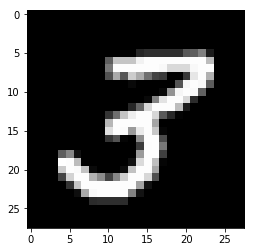

sample.max() 1.0
label [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
teacher.predict [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
teacher.predict_softened [[0.000e+00 0.000e+00 0.000e+00 9.998e-01 0.000e+00 1.000e-04 0.000e+00
  0.000e+00 1.000e-04 0.000e+00]]


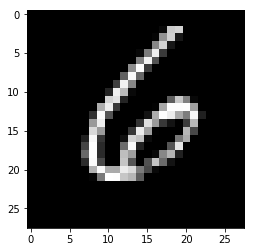

sample.max() 1.0
label [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
teacher.predict [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
teacher.predict_softened [[1.900e-03 2.000e-04 6.000e-04 5.000e-04 6.000e-04 7.000e-03 9.825e-01
  6.000e-04 4.900e-03 1.200e-03]]


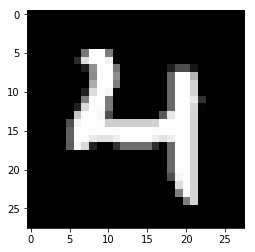

sample.max() 1.0
label [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
teacher.predict [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
teacher.predict_softened [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [8]:
# plot and show sample
if try_cls2:
    n_samples = 6
    round_show = 4
    t = 10
    X_show = X_train
    n_data = X_show.shape[0]
    indices = np.random.choice(n_data,n_samples)
    for i in range(n_samples):
        sample = X_show[[indices[i]]]
        label = y_train[indices[i]]
        plt.imshow(sample.reshape((28,28)), cmap='gray')
        plt.show()
        pred = teacher.predict(sample)
        pred_t = teacher.predict_softened(sample, temperature=t)
#         pred_t2 = y_train_soft[indices[i]]
        print('sample.max()',sample.max())
        print('label',label)
        print('teacher.predict',np.round(pred,round_show))
        print('teacher.predict_softened',np.round(pred_t,round_show))
#         print('y_soft',np.round(pred_t2,round_show))
        #     teacher.predict()

In [9]:

def build_small_model(input_dims, output_dims, session, is_student):
    smallmodel = StudentNN(
        input_dims=input_dims
        , output_dims=output_dims
        , session=session
        , dtype_X=tf.float32
        , dtype_y=tf.float32)

    smallmodel.add_layer(
        FC(inputs=smallmodel.h[-1],out_dims=800,activation_fn=tf.nn.relu))
    smallmodel.add_layer(
        FC(inputs=smallmodel.h[-1],out_dims=800,activation_fn=tf.nn.relu))
    smallmodel.add_layer(
        FC(inputs=smallmodel.h[-1],out_dims=output_dims, activation_fn=tf.nn.softmax))

    if is_student:
        smallmodel.compile_student(
            loss_standard=tf.losses.softmax_cross_entropy(smallmodel.ys,smallmodel.logits)
            , opt=tf.train.AdamOptimizer(learning_rate=1e-3) #TODO: learning rate
            , metrics = ['acc']
        )
    else:
        smallmodel.compile_nn(
            loss=tf.losses.softmax_cross_entropy(smallmodel.ys,smallmodel.logits)
            , opt=tf.train.AdamOptimizer(learning_rate=1e-3)
            , metrics = ['acc']
        )
    return smallmodel

In [10]:
import gc
gc.collect()
if try_cls2:
    small = build_small_model(input_dims, output_dims, session, is_student=False)
    small.train(
        X=X_train
        ,y=y_train
        ,val_set=[X_val,y_val]
        ,batch_size=100
        ,n_epochs=50
        ,display_steps=100)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14902419298862029707
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3649503232
locality {
  bus_id: 1
}
incarnation: 10222180091873995020
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1"
]
Epoch 1 , step 0 , loss= 3.6970859 , acc = 0.27 
Epoch 1 , step 100 , loss= 0.31899762 , acc = 0.93 
Epoch 1 , step 200 , loss= 0.10418472 , acc = 0.97 
Epoch 1 , step 300 , loss= 0.078691855 , acc = 0.98 
Epoch 1 , step 400 , loss= 0.055572387 , acc = 0.99 
Epoch 1 , step 500 , loss= 0.13739395 , acc = 0.94 
Epoch 1 , step 549 , loss= 0.16370896 val_loss= 0.1003701 , acc = 0.94 val acc = 0.9696 
Epoch 1 finished, loss= 0.18536487 val loss= 0.1003701 ,  acc = 0.9484 val acc = 0.9696

Epoch 2 , step 50 , loss= 0.060633678 , acc = 0.97 
Epoch 2 , step 150 , loss= 0.06170709 , acc = 0.98 
Epoch 2 , step 250 , loss= 0.04466839 , acc = 0.98 
E

Epoch 17 , step 400 , loss= 2.4668137e-05 , acc = 1.0 
Epoch 17 , step 500 , loss= 0.00013653858 , acc = 1.0 
Epoch 17 , step 549 , loss= 0.007982972 val_loss= 0.10448865 , acc = 1.0 val acc = 0.983 
Epoch 17 finished, loss= 0.0015471465 val loss= 0.10448865 ,  acc = 0.99972725 val acc = 0.983

Epoch 18 , step 50 , loss= 0.003425138 , acc = 1.0 
Epoch 18 , step 150 , loss= 0.0007123425 , acc = 1.0 
Epoch 18 , step 250 , loss= 0.0004949001 , acc = 1.0 
Epoch 18 , step 350 , loss= 0.0011904015 , acc = 1.0 
Epoch 18 , step 450 , loss= 3.4401597e-05 , acc = 1.0 
Epoch 18 , step 549 , loss= 0.00094089203 val_loss= 0.102067776 , acc = 1.0 val acc = 0.9828 
Epoch 18 finished, loss= 0.0022481913 val loss= 0.102067776 ,  acc = 0.9995819 val acc = 0.9828

Epoch 19 , step 0 , loss= 3.0482106e-05 , acc = 1.0 
Epoch 19 , step 100 , loss= 0.00040609937 , acc = 1.0 
Epoch 19 , step 200 , loss= 0.0006956884 , acc = 1.0 
Epoch 19 , step 300 , loss= 0.00038125197 , acc = 1.0 
Epoch 19 , step 400 , loss=

Small model
Plotting loss...


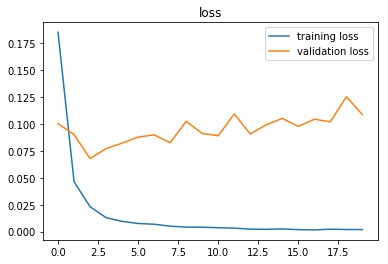

Plotting metrics...


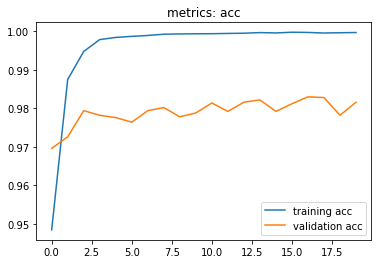

train {'acc': 0.9968909}
test {'acc': 0.9788}


In [11]:
if try_cls2:
    print('Small model')
    small.plt_loss()
    small.plt_metrics()
    train_metric = small.get_metrics(X_train, y_train)
    test_metric = small.get_metrics(X_test, y_test)
    print('train',train_metric)
    print('test',test_metric)

Training student with temperature = 2 , coef = 0.25 .
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14097591513317717662
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3649503232
locality {
  bus_id: 1
}
incarnation: 8752449068422321964
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1"
]
Epoch 1 , step 0 , loss= 3.1396387 , acc = 0.29 
t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.027352000000007592
loss_train : 0.013778000000002066
metric batch : 0.007299000000045908
whole : 0.048829000000012
display_whole : 0.02145899999999301
Epoch 1 , step 100 , loss= 0.81799555 , acc = 0.94 
t_cost <class 'dict'> 
get_batch : 4.9999999873762135e-06
train_op : 0.0033389999999826614
loss_train : 0.006107999999983349
metric batch : 0.001760999999987689
whole : 0.011648000000036518
display_whole : 0.008300000000019736
Epoch 1 , step 200 , loss= 0.7625953 , acc =

Epoch 5 , step 100 , loss= 0.6288111 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 3.999999989900971e-06
train_op : 0.0033589999999890097
loss_train : 0.0022480000000086875
metric batch : 0.0016609999999559477
whole : 0.007720000000006166
display_whole : 0.004351999999983036
Epoch 5 , step 200 , loss= 0.625531 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 4.9999999873762135e-06
train_op : 0.0032850000000053114
loss_train : 0.0027129999999715437
metric batch : 0.0015720000000101209
whole : 0.007997999999986405
display_whole : 0.004703999999946973
Epoch 5 , step 300 , loss= 0.6182913 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 4.9999999873762135e-06
train_op : 0.0035330000000044492
loss_train : 0.0021300000000223918
metric batch : 0.0017439999999737665
whole : 0.007840999999984888
display_whole : 0.004302999999993062
Epoch 5 , step 400 , loss= 0.60708976 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.0042870000000334585
loss_train : 0.002818999

Epoch 9 , step 300 , loss= 0.6081806 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 4.9999999873762135e-06
train_op : 0.003470999999990454
loss_train : 0.0024819999999863285
metric batch : 0.0016719999999850188
whole : 0.008114000000034594
display_whole : 0.004637000000002445
Epoch 9 , step 400 , loss= 0.6012992 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.0035809999999969477
loss_train : 0.00275800000002846
metric batch : 0.0014830000000074506
whole : 0.008304999999950269
display_whole : 0.004714000000035412
Epoch 9 , step 500 , loss= 0.619992 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 3.999999989900971e-06
train_op : 0.0031390000000328655
loss_train : 0.002476000000001477
metric batch : 0.0017589999999927386
whole : 0.007771999999988566
display_whole : 0.0046280000000251675
Epoch 9 , step 549 , loss= 0.6059458 val_loss= 0.66924316 , acc = 1.0 val acc = 0.982 
Epoch 9 finished, loss= 0.6870722 t_cost <class 'dict'> 
get_batch : 4.99999998737

Epoch 13 , step 500 , loss= 0.6134815 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 3.999999989900971e-06
train_op : 0.003382999999985259
loss_train : 0.0025689999999940483
metric batch : 0.0015980000000013206
whole : 0.008007000000020525
display_whole : 0.004617999999993572
Epoch 13 , step 549 , loss= 0.6029757 val_loss= 0.6602509 , acc = 1.0 val acc = 0.9824 
Epoch 13 finished, loss= 0.66295594 t_cost <class 'dict'> 
get_batch : 4.9999999873762135e-06
train_op : 0.003933000000017728
loss_train : 0.012326000000030035
loss_val : 0.027248999999983425
metric_val : 0.022306000000014592
metric batch : 0.0015409999999747015
whole : 0.06809399999997368
display_whole : 0.06415200000003551
Epoch 14 , step 50 , loss= 0.5915713 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 4.9999999873762135e-06
train_op : 0.0033840000000395776
loss_train : 0.0027529999999842403
metric batch : 0.0022069999999985157
whole : 0.008739999999988868
display_whole : 0.005351999999959389
Epoch 14 , step 150 , loss= 

Epoch 18 , step 50 , loss= 0.5750304 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 6.000000041694875e-06
train_op : 0.003489999999999327
loss_train : 0.0025959999999827232
metric batch : 0.001740000000040709
whole : 0.00817100000000437
display_whole : 0.004668999999978496
Epoch 18 , step 150 , loss= 0.6054403 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.000000044219632e-06
train_op : 0.0036059999999906722
loss_train : 0.0027039999999942665
metric batch : 0.0016329999999697975
whole : 0.008366000000023632
display_whole : 0.004749000000003889
Epoch 18 , step 250 , loss= 0.60606146 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 4.00000004674439e-06
train_op : 0.0033939999999574866
loss_train : 0.002510999999969954
metric batch : 0.00162900000003674
whole : 0.007949999999993906
display_whole : 0.004547000000002299
Epoch 18 , step 350 , loss= 0.6078315 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 3.999999989900971e-06
train_op : 0.003353000000004158
loss_train : 0.002711999999974

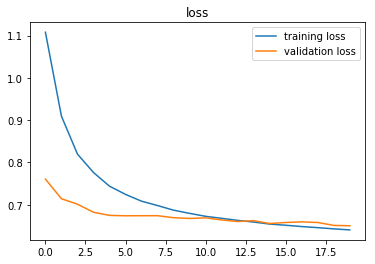

Plotting metrics...


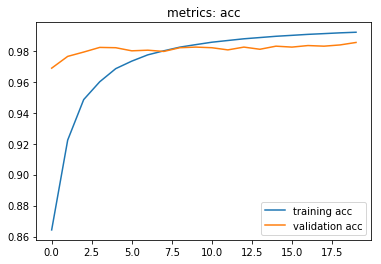

train {'acc': 0.9999818}
test {'acc': 0.9806}

Training student with temperature = 2 , coef = 1 .
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 426160207826142210
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3649503232
locality {
  bus_id: 1
}
incarnation: 7311921077749182526
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1"
]
Epoch 1 , step 0 , loss= 7.3189235 , acc = 0.14 
t_cost <class 'dict'> 
get_batch : 4.9999999873762135e-06
train_op : 0.030619000000001506
loss_train : 0.020541000000037002
metric batch : 0.009397999999976037
whole : 0.06086800000002768
display_whole : 0.030227000000024873
Epoch 1 , step 100 , loss= 2.4103289 , acc = 0.89 
t_cost <class 'dict'> 
get_batch : 3.999999989900971e-06
train_op : 0.0033010000000217588
loss_train : 0.002808000000015909
metric batch : 0.0018099999999776628
whole : 0.00840299999998706
display_whole : 0.005096999999977925


Epoch 5 , step 100 , loss= 2.1455598 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 4.9999999873762135e-06
train_op : 0.0034380000000169275
loss_train : 0.0030069999999682295
metric batch : 0.0017370000000482833
whole : 0.008563999999978478
display_whole : 0.005119999999976699
Epoch 5 , step 200 , loss= 2.0553062 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.0034880000000043765
loss_train : 0.0028029999999716892
metric batch : 0.0017129999999951906
whole : 0.008319000000028609
display_whole : 0.004828999999972439
Epoch 5 , step 300 , loss= 2.0155287 , acc = 0.98 
t_cost <class 'dict'> 
get_batch : 7.000000039170118e-06
train_op : 0.003977999999960957
loss_train : 0.010393999999962489
metric batch : 0.0017809999999940374
whole : 0.016606000000024324
display_whole : 0.012618999999972402
Epoch 5 , step 400 , loss= 2.1008365 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.0033510000000092077
loss_train : 0.00267000000

Epoch 9 , step 300 , loss= 2.0734642 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 3.999999989900971e-06
train_op : 0.0031740000000013424
loss_train : 0.0025850000000104956
metric batch : 0.0018259999999941101
whole : 0.00809500000002572
display_whole : 0.004916000000037002
Epoch 9 , step 400 , loss= 2.0199065 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.003558999999995649
loss_train : 0.0028309999999578395
metric batch : 0.0015829999999823485
whole : 0.008417000000008557
display_whole : 0.0048429999999939355
Epoch 9 , step 500 , loss= 2.0115504 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.004444999999975607
loss_train : 0.0029030000000034306
metric batch : 0.0016569999999660467
whole : 0.009510999999974956
display_whole : 0.005051999999977852
Epoch 9 , step 549 , loss= 2.0243342 val_loss= 2.0934312 , acc = 1.0 val acc = 0.967 
Epoch 9 finished, loss= 2.1774893 t_cost <class 'dict'> 
get_batch : 5.99999998485

Epoch 13 , step 500 , loss= 1.9275708 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.000000044219632e-06
train_op : 0.0034279999999853317
loss_train : 0.002778000000034808
metric batch : 0.0015899999999646752
whole : 0.008163000000024567
display_whole : 0.004723000000012689
Epoch 13 , step 549 , loss= 2.043712 val_loss= 2.0813575 , acc = 1.0 val acc = 0.9688 
Epoch 13 finished, loss= 2.1361568 t_cost <class 'dict'> 
get_batch : 3.999999989900971e-06
train_op : 0.0038559999999847605
loss_train : 0.010739000000000942
loss_val : 0.02375000000000682
metric_val : 0.0221260000000143
metric batch : 0.0014130000000136533
whole : 0.06264899999996487
display_whole : 0.058782000000007884
Epoch 14 , step 50 , loss= 2.0151737 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 4.9999999873762135e-06
train_op : 0.0033500000000117325
loss_train : 0.0034100000000307773
metric batch : 0.0016089999999735483
whole : 0.008811999999977616
display_whole : 0.005456000000037875
Epoch 14 , step 150 , loss= 2.06

Epoch 18 , step 50 , loss= 2.0800266 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 6.999999982326699e-06
train_op : 0.003841000000022632
loss_train : 0.002751999999986765
metric batch : 0.001472000000035223
whole : 0.008508000000006177
display_whole : 0.004658000000006268
Epoch 18 , step 150 , loss= 1.9714986 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 4.9999999873762135e-06
train_op : 0.00388700000002018
loss_train : 0.0029989999999884276
metric batch : 0.0018049999999902866
whole : 0.009204999999951724
display_whole : 0.00530900000001111
Epoch 18 , step 250 , loss= 1.9442906 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 3.999999989900971e-06
train_op : 0.0034919999999942775
loss_train : 0.0027140000000258624
metric batch : 0.001760999999987689
whole : 0.008416999999951713
display_whole : 0.004921000000024378
Epoch 18 , step 350 , loss= 1.9522786 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 3.999999989900971e-06
train_op : 0.0034579999999664324
loss_train : 0.00661499999995

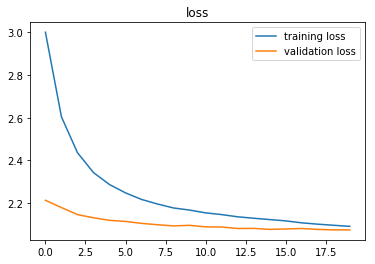

Plotting metrics...


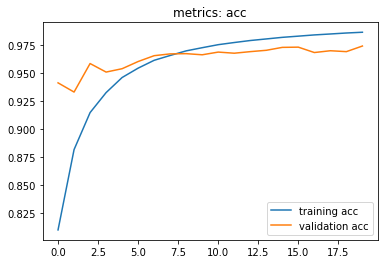

train {'acc': 0.99912727}
test {'acc': 0.9669}

Training student with temperature = 2 , coef = 4 .
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4371173273770073562
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3649503232
locality {
  bus_id: 1
}
incarnation: 839019090189988133
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1"
]
Epoch 1 , step 0 , loss= 12.654968 , acc = 0.15 
t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.03261400000002368
loss_train : 0.01675900000003594
metric batch : 0.011114999999961128
whole : 0.06079299999998966
display_whole : 0.028157000000021526
Epoch 1 , step 100 , loss= 7.082738 , acc = 0.45 
t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.0046859999999924185
loss_train : 0.0034840000000144755
metric batch : 0.0017129999999951906
whole : 0.010257999999964795
display_whole : 0.005556000000012773
E

Epoch 5 , step 100 , loss= 6.819355 , acc = 0.49 
t_cost <class 'dict'> 
get_batch : 3.999999989900971e-06
train_op : 0.0032810000000154105
loss_train : 0.0028879999999844586
metric batch : 0.0016359999999622232
whole : 0.008318999999971766
display_whole : 0.0049849999999764805
Epoch 5 , step 200 , loss= 7.009033 , acc = 0.61 
t_cost <class 'dict'> 
get_batch : 6.999999982326699e-06
train_op : 0.0036239999999452266
loss_train : 0.002718999999956395
metric batch : 0.0016989999999736938
whole : 0.008452000000033877
display_whole : 0.004817000000002736
Epoch 5 , step 300 , loss= 6.790356 , acc = 0.45 
t_cost <class 'dict'> 
get_batch : 6.000000041694875e-06
train_op : 0.0034689999999955035
loss_train : 0.002621999999973923
metric batch : 0.0017310000000065884
whole : 0.008264999999994416
display_whole : 0.004782999999974891
Epoch 5 , step 400 , loss= 6.980692 , acc = 0.5 
t_cost <class 'dict'> 
get_batch : 4.9999999873762135e-06
train_op : 0.0037459999999782667
loss_train : 0.007238999999

Epoch 9 , step 300 , loss= 6.85999 , acc = 0.42 
t_cost <class 'dict'> 
get_batch : 7.999999979801942e-06
train_op : 0.0037780000000111613
loss_train : 0.002789000000007036
metric batch : 0.002119999999990796
whole : 0.009117000000003372
display_whole : 0.005329000000017459
Epoch 9 , step 400 , loss= 6.8130746 , acc = 0.49 
t_cost <class 'dict'> 
get_batch : 6.999999982326699e-06
train_op : 0.0038099999999872125
loss_train : 0.003964999999993779
metric batch : 0.0017470000000230357
whole : 0.009992000000011103
display_whole : 0.006168000000002394
Epoch 9 , step 500 , loss= 6.6295342 , acc = 0.49 
t_cost <class 'dict'> 
get_batch : 3.999999989900971e-06
train_op : 0.003367999999966287
loss_train : 0.0032519999999749416
metric batch : 0.0020650000000159707
whole : 0.009752999999989242
display_whole : 0.0063779999999837855
Epoch 9 , step 549 , loss= 6.865011 val_loss= 6.8923187 , acc = 0.42 val acc = 0.4832 
Epoch 9 finished, loss= 6.9979796 t_cost <class 'dict'> 
get_batch : 5.9999999848

Epoch 13 , step 500 , loss= 6.796138 , acc = 0.5 
t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.003819000000021333
loss_train : 0.002727999999990516
metric batch : 0.0016939999999863176
whole : 0.008726000000024214
display_whole : 0.004897000000028129
Epoch 13 , step 549 , loss= 6.8432198 val_loss= 6.8740883 , acc = 0.48 val acc = 0.4462 
Epoch 13 finished, loss= 6.9105654 t_cost <class 'dict'> 
get_batch : 4.9999999873762135e-06
train_op : 0.0036499999999932697
loss_train : 0.0026399999999853208
loss_val : 0.024046999999995933
metric_val : 0.022304999999960273
metric batch : 0.0020989999999869724
whole : 0.05556200000000899
display_whole : 0.05190399999997908
Epoch 14 , step 50 , loss= 6.778503 , acc = 0.55 
t_cost <class 'dict'> 
get_batch : 6.999999982326699e-06
train_op : 0.004470000000026175
loss_train : 0.009821000000044933
metric batch : 0.002323999999987336
whole : 0.01695999999998321
display_whole : 0.012480000000039126
Epoch 14 , step 150 , loss= 6.914

Epoch 18 , step 50 , loss= 6.814806 , acc = 0.44 
t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.0038940000000025066
loss_train : 0.0034790000000270993
metric batch : 0.0018969999999853826
whole : 0.009649999999965075
display_whole : 0.005745000000047185
Epoch 18 , step 150 , loss= 6.6781845 , acc = 0.52 
t_cost <class 'dict'> 
get_batch : 6.999999982326699e-06
train_op : 0.0038700000000062573
loss_train : 0.0027000000000043656
metric batch : 0.00171100000000024
whole : 0.008622000000002572
display_whole : 0.004741000000024087
Epoch 18 , step 250 , loss= 6.5135965 , acc = 0.41 
t_cost <class 'dict'> 
get_batch : 4.9999999873762135e-06
train_op : 0.004221000000029562
loss_train : 0.003027999999972053
metric batch : 0.0019409999999879801
whole : 0.009593999999992775
display_whole : 0.005361999999990985
Epoch 18 , step 350 , loss= 6.988163 , acc = 0.5 
t_cost <class 'dict'> 
get_batch : 5.000000044219632e-06
train_op : 0.0038559999999847605
loss_train : 0.0122780000

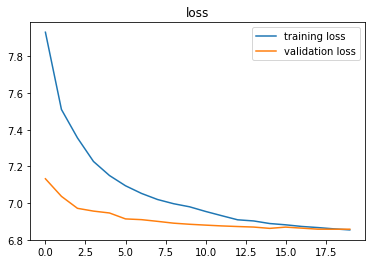

Plotting metrics...


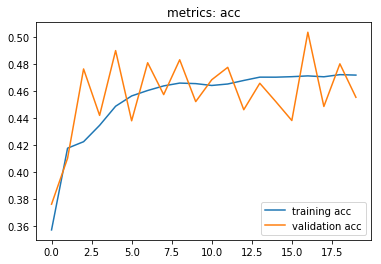

train {'acc': 0.48956364}
test {'acc': 0.462}

Training student with temperature = 4 , coef = 0.0625 .
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17673791756717473942
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3112632320
locality {
  bus_id: 1
}
incarnation: 16524862073250501475
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1"
]
Epoch 1 , step 0 , loss= 2.6428134 , acc = 0.46 
t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.03365999999999758
loss_train : 0.018191999999999098
metric batch : 0.012975000000039927
whole : 0.06530099999997674
display_whole : 0.03162299999996776
Epoch 1 , step 100 , loss= 0.25045 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 3.999999989900971e-06
train_op : 0.0030790000000138207
loss_train : 0.0027690000000006876
metric batch : 0.001932000000010703
whole : 0.008246999999983018
display_whole : 0.0051630000000386

Epoch 5 , step 100 , loss= 0.17236754 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 4.9999999873762135e-06
train_op : 0.003715999999997166
loss_train : 0.0043870000000083564
metric batch : 0.0019279999999639585
whole : 0.010441000000014355
display_whole : 0.006715999999983069
Epoch 5 , step 200 , loss= 0.16421412 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 4.00000004674439e-06
train_op : 0.0031399999999734973
loss_train : 0.0025580000000218206
metric batch : 0.001679000000024189
whole : 0.007894000000021606
display_whole : 0.0047470000000089385
Epoch 5 , step 300 , loss= 0.16560288 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 4.9999999873762135e-06
train_op : 0.003512999999998101
loss_train : 0.0029410000000211767
metric batch : 0.0016889999999989413
whole : 0.008795999999961168
display_whole : 0.0052740000000426335
Epoch 5 , step 400 , loss= 0.17041281 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 4.9999999873762135e-06
train_op : 0.00374600000003511
loss_train : 0.00263699

Epoch 9 , step 300 , loss= 0.15756623 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 6.999999982326699e-06
train_op : 0.003593000000023494
loss_train : 0.002264000000025135
metric batch : 0.0017330000000015389
whole : 0.008020999999985179
display_whole : 0.004415999999991982
Epoch 9 , step 400 , loss= 0.15938024 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.003444999999999254
loss_train : 0.01017300000000887
metric batch : 0.0020199999999590545
whole : 0.016108000000031097
display_whole : 0.012653000000000247
Epoch 9 , step 500 , loss= 0.15799728 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.999999979801942e-06
train_op : 0.003719000000046435
loss_train : 0.0037629999999921893
metric batch : 0.0020379999999704523
whole : 0.009950000000003456
display_whole : 0.0062130000000024665
Epoch 9 , step 549 , loss= 0.15894124 val_loss= 0.2020346 , acc = 1.0 val acc = 0.988 
Epoch 9 finished, loss= 0.22482371 t_cost <class 'dict'> 
get_batch : 5.999999984

Epoch 13 , step 500 , loss= 0.18564197 , acc = 0.99 
t_cost <class 'dict'> 
get_batch : 6.000000041694875e-06
train_op : 0.0036299999999869215
loss_train : 0.00281200000000581
metric batch : 0.0020109999999817774
whole : 0.00880899999998519
display_whole : 0.00516600000003109
Epoch 13 , step 549 , loss= 0.17627311 val_loss= 0.2349647 , acc = 1.0 val acc = 0.98 
Epoch 13 finished, loss= 0.20695898 t_cost <class 'dict'> 
get_batch : 5.000000044219632e-06
train_op : 0.0036259999999970205
loss_train : 0.0027150000000233376
loss_val : 0.026459000000045307
metric_val : 0.021145999999987453
metric batch : 0.0016359999999622232
whole : 0.056357000000048174
display_whole : 0.05272100000001956
Epoch 14 , step 50 , loss= 0.1688868 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.0036979999999857682
loss_train : 0.002670000000023265
metric batch : 0.0017260000000192122
whole : 0.008549000000016349
display_whole : 0.0048429999999939355
Epoch 14 , step 150 , loss= 0

Epoch 18 , step 50 , loss= 0.15779129 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 4.00000004674439e-06
train_op : 0.003295999999977539
loss_train : 0.0027100000000359614
metric batch : 0.001986999999985528
whole : 0.008432000000027529
display_whole : 0.005129000000010819
Epoch 18 , step 150 , loss= 0.15751079 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 3.999999989900971e-06
train_op : 0.0034239999999954307
loss_train : 0.005505000000027849
metric batch : 0.0018200000000092587
whole : 0.011181000000021868
display_whole : 0.007747999999992317
Epoch 18 , step 250 , loss= 0.1581946 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 9.999999974752427e-06
train_op : 0.003988999999990028
loss_train : 0.002838999999994485
metric batch : 0.001752000000010412
whole : 0.008963999999991756
display_whole : 0.004962999999975182
Epoch 18 , step 350 , loss= 0.15945043 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.003558999999995649
loss_train : 0.0029890000000

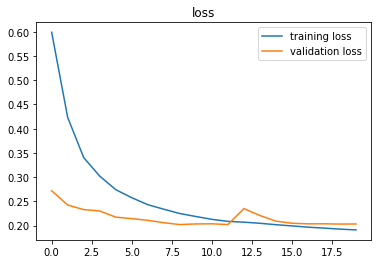

Plotting metrics...


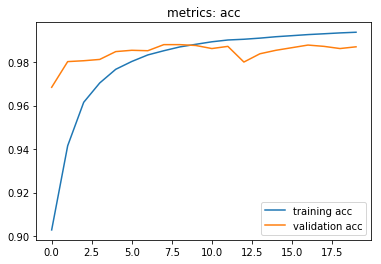

train {'acc': 1.0}
test {'acc': 0.9854}

Training student with temperature = 4 , coef = 1 .
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 443211690050812036
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3112632320
locality {
  bus_id: 1
}
incarnation: 1078914975067241389
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1"
]
Epoch 1 , step 0 , loss= 6.295103 , acc = 0.29 
t_cost <class 'dict'> 
get_batch : 4.9999999873762135e-06
train_op : 0.0358229999999935
loss_train : 0.021579999999971733
metric batch : 0.015348000000017237
whole : 0.07311599999997043
display_whole : 0.03727299999997058
Epoch 1 , step 100 , loss= 2.4886045 , acc = 0.97 
t_cost <class 'dict'> 
get_batch : 6.999999982326699e-06
train_op : 0.0034560000000283253
loss_train : 0.003330000000005384
metric batch : 0.0018070000000420805
whole : 0.0090720000000033
display_whole : 0.005607999999995172
Epoch 1 , s

Epoch 5 , step 100 , loss= 2.2663205 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 3.999999989900971e-06
train_op : 0.004549999999994725
loss_train : 0.0024599999999850297
metric batch : 0.001944999999977881
whole : 0.009465999999974883
display_whole : 0.004907000000002881
Epoch 5 , step 200 , loss= 2.2876031 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.000000039170118e-06
train_op : 0.0045440000000098735
loss_train : 0.0026159999999890715
metric batch : 0.001955000000009477
whole : 0.00948300000004565
display_whole : 0.0049270000000092296
Epoch 5 , step 300 , loss= 2.2787266 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 4.9999999873762135e-06
train_op : 0.0050919999999905485
loss_train : 0.006634000000019569
metric batch : 0.00164999999998372
whole : 0.013907000000017433
display_whole : 0.008803000000000338
Epoch 5 , step 400 , loss= 2.3000212 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 4.9999999873762135e-06
train_op : 0.0032310000000279615
loss_train : 0.002679000000000

Epoch 9 , step 300 , loss= 2.299211 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 4.9999999873762135e-06
train_op : 0.003581999999994423
loss_train : 0.0024129999999900065
metric batch : 0.0017009999999686443
whole : 0.008131000000048516
display_whole : 0.0045400000000199725
Epoch 9 , step 400 , loss= 2.2819188 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 4.00000004674439e-06
train_op : 0.0034849999999551073
loss_train : 0.0029059999999958563
metric batch : 0.001833999999973912
whole : 0.008609000000035394
display_whole : 0.005112999999994372
Epoch 9 , step 500 , loss= 2.2756822 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 4.9999999873762135e-06
train_op : 0.003988999999990028
loss_train : 0.010237999999958447
metric batch : 0.001993000000027223
whole : 0.016593999999997777
display_whole : 0.012594999999976153
Epoch 9 , step 549 , loss= 2.2799373 val_loss= 2.3415246 , acc = 1.0 val acc = 0.982 
Epoch 9 finished, loss= 2.3892639 t_cost <class 'dict'> 
get_batch : 3.9999999899009

Epoch 13 , step 500 , loss= 2.2857256 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.000000044219632e-06
train_op : 0.0032019999999874926
loss_train : 0.0026439999999752217
metric batch : 0.001542999999969652
whole : 0.00785400000000891
display_whole : 0.004645999999979722
Epoch 13 , step 549 , loss= 2.2855582 val_loss= 2.3334363 , acc = 1.0 val acc = 0.9816 
Epoch 13 finished, loss= 2.3556392 t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.004795999999998912
loss_train : 0.002823000000034881
loss_val : 0.023941000000036183
metric_val : 0.022167999999965105
metric batch : 0.0015089999999986503
whole : 0.056048000000032516
display_whole : 0.05123800000001211
Epoch 14 , step 50 , loss= 2.259652 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.000000039170118e-06
train_op : 0.004010999999991327
loss_train : 0.007323999999982789
metric batch : 0.0024280000000089785
whole : 0.014139999999997599
display_whole : 0.010120000000028995
Epoch 14 , step 150 , loss= 2.2730

Epoch 18 , step 50 , loss= 2.27368 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 4.9999999873762135e-06
train_op : 0.004112000000020544
loss_train : 0.010199000000000069
metric batch : 0.0021250000000350155
whole : 0.016940999999974338
display_whole : 0.01282000000003336
Epoch 18 , step 150 , loss= 2.2691727 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.000000044219632e-06
train_op : 0.003260000000011587
loss_train : 0.0022679999999581923
metric batch : 0.002277999999989788
whole : 0.008144000000015694
display_whole : 0.004876999999964937
Epoch 18 , step 250 , loss= 2.2528818 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 3.999999989900971e-06
train_op : 0.0032090000000266627
loss_train : 0.0026960000000144646
metric batch : 0.0017179999999825668
whole : 0.007978999999977532
display_whole : 0.004760999999973592
Epoch 18 , step 350 , loss= 2.2646418 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 4.9999999873762135e-06
train_op : 0.0032950000000369073
loss_train : 0.0026970000000

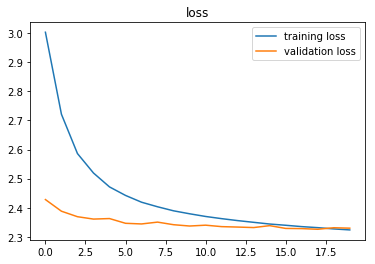

Plotting metrics...


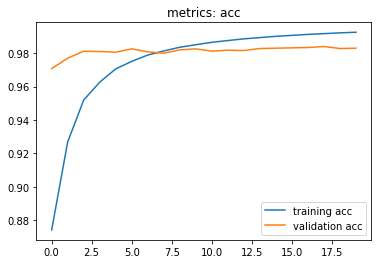

train {'acc': 0.9999091}
test {'acc': 0.9817}

Training student with temperature = 4 , coef = 16 .
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10213013886588322223
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3112632320
locality {
  bus_id: 1
}
incarnation: 12258074805121201077
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1"
]
Epoch 1 , step 0 , loss= 42.915394 , acc = 0.16 
t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.040115000000014334
loss_train : 0.022406000000046333
metric batch : 0.01611400000001595
whole : 0.07907299999999395
display_whole : 0.03893700000003264
Epoch 1 , step 100 , loss= 34.10082 , acc = 0.55 
t_cost <class 'dict'> 
get_batch : 6.999999982326699e-06
train_op : 0.0041509999999789216
loss_train : 0.0026699999999664215
metric batch : 0.0017119999999977153
whole : 0.008872999999994136
display_whole : 0.00470599999994192

Epoch 5 , step 100 , loss= 33.472233 , acc = 0.66 
t_cost <class 'dict'> 
get_batch : 3.999999989900971e-06
train_op : 0.0034309999999777574
loss_train : 0.0025750000000925866
metric batch : 0.0016010000000505897
whole : 0.00802499999997508
display_whole : 0.00458400000002257
Epoch 5 , step 200 , loss= 33.970444 , acc = 0.7 
t_cost <class 'dict'> 
get_batch : 5.000000101063051e-06
train_op : 0.003198999999995067
loss_train : 0.002672999999958847
metric batch : 0.0018489999999928841
whole : 0.008192000000008193
display_whole : 0.004986000000030799
Epoch 5 , step 300 , loss= 33.873024 , acc = 0.71 
t_cost <class 'dict'> 
get_batch : 6.000000098538294e-06
train_op : 0.003601000000003296
loss_train : 0.0080600000000004
metric batch : 0.0018560000000888977
whole : 0.013882000000080552
display_whole : 0.010272999999983767
Epoch 5 , step 400 , loss= 34.160095 , acc = 0.75 
t_cost <class 'dict'> 
get_batch : 3.999999989900971e-06
train_op : 0.0035410000000410946
loss_train : 0.0024720000000115

Epoch 9 , step 300 , loss= 33.567238 , acc = 0.65 
t_cost <class 'dict'> 
get_batch : 4.9999999873762135e-06
train_op : 0.003362000000038279
loss_train : 0.002953000000047723
metric batch : 0.0016460000000506625
whole : 0.008335999999985688
display_whole : 0.004968999999960033
Epoch 9 , step 400 , loss= 33.774166 , acc = 0.71 
t_cost <class 'dict'> 
get_batch : 4.9999999873762135e-06
train_op : 0.0036820000000261643
loss_train : 0.002691999999910877
metric batch : 0.001836000000025706
whole : 0.00853899999992791
display_whole : 0.004846999999926993
Epoch 9 , step 500 , loss= 33.683167 , acc = 0.76 
t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.0034889999999450083
loss_train : 0.002253999999993539
metric batch : 0.0016949999999269494
whole : 0.0077810000000226864
display_whole : 0.004279999999994288
Epoch 9 , step 549 , loss= 33.773758 val_loss= 33.946804 , acc = 0.75 val acc = 0.675 
Epoch 9 finished, loss= 34.062607 t_cost <class 'dict'> 
get_batch : 3.99999998

Epoch 13 , step 500 , loss= 33.83854 , acc = 0.68 
t_cost <class 'dict'> 
get_batch : 6.999999982326699e-06
train_op : 0.00470600000005561
loss_train : 0.0028170000000500295
metric batch : 0.0021419999999352513
whole : 0.010103000000071916
display_whole : 0.0053850000000466025
Epoch 13 , step 549 , loss= 33.580093 val_loss= 33.927704 , acc = 0.73 val acc = 0.684 
Epoch 13 finished, loss= 33.962254 t_cost <class 'dict'> 
get_batch : 6.999999982326699e-06
train_op : 0.0039289999999709835
loss_train : 0.002705999999989217
loss_val : 0.0344399999999041
metric_val : 0.02119900000002417
metric batch : 0.001426000000037675
whole : 0.06443799999999555
display_whole : 0.06049400000006244
Epoch 14 , step 50 , loss= 33.957024 , acc = 0.7 
t_cost <class 'dict'> 
get_batch : 4.9999999873762135e-06
train_op : 0.004431999999951586
loss_train : 0.0030270000000882646
metric batch : 0.0018559999999752108
whole : 0.009707999999932326
display_whole : 0.005261000000018612
Epoch 14 , step 150 , loss= 33.586

Epoch 18 , step 50 , loss= 34.230038 , acc = 0.71 
t_cost <class 'dict'> 
get_batch : 4.9999999873762135e-06
train_op : 0.0036999999999807187
loss_train : 0.0027629999999589927
metric batch : 0.0019310000000132277
whole : 0.008829999999989013
display_whole : 0.0051249999999072315
Epoch 18 , step 150 , loss= 33.80149 , acc = 0.73 
t_cost <class 'dict'> 
get_batch : 3.999999989900971e-06
train_op : 0.003634000000033666
loss_train : 0.0027709999999387946
metric batch : 0.001790000000028158
whole : 0.00850399999990259
display_whole : 0.004863000000000284
Epoch 18 , step 250 , loss= 33.446556 , acc = 0.7 
t_cost <class 'dict'> 
get_batch : 4.9999999873762135e-06
train_op : 0.0034229999999979555
loss_train : 0.0029560000000401487
metric batch : 0.0019019999999727588
whole : 0.008609999999976026
display_whole : 0.005176000000005843
Epoch 18 , step 350 , loss= 33.54716 , acc = 0.73 
t_cost <class 'dict'> 
get_batch : 6.999999982326699e-06
train_op : 0.003563999999983025
loss_train : 0.00263299

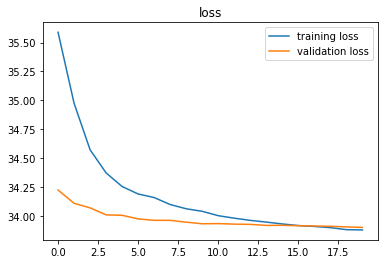

Plotting metrics...


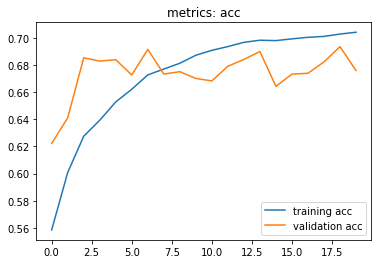

train {'acc': 0.7324}
test {'acc': 0.6816}

Training student with temperature = 8 , coef = 0.015625 .
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11659706866072237143
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3112632320
locality {
  bus_id: 1
}
incarnation: 4225316830268888301
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1"
]
Epoch 1 , step 0 , loss= 3.010103 , acc = 0.27 
t_cost <class 'dict'> 
get_batch : 4.9999999873762135e-06
train_op : 0.03743599999995695
loss_train : 0.03275600000006307
metric batch : 0.01763800000003357
whole : 0.08815800000002127
display_whole : 0.05070299999999861
Epoch 1 , step 100 , loss= 0.16824394 , acc = 0.97 
t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.003547000000025946
loss_train : 0.004688999999984844
metric batch : 0.001760999999987689
whole : 0.010594999999966603
display_whole : 0.007037999999965905

Epoch 5 , step 100 , loss= 0.04437118 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.0033190000000331565
loss_train : 0.002751999999986765
metric batch : 0.001966000000038548
whole : 0.008297999999967942
display_whole : 0.004969999999957508
Epoch 5 , step 200 , loss= 0.04879397 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 6.999999982326699e-06
train_op : 0.0037379999999984648
loss_train : 0.0021560000000135915
metric batch : 0.0017840000000433065
whole : 0.008148000000005595
display_whole : 0.0043980000000374275
Epoch 5 , step 300 , loss= 0.04597607 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 4.9999999873762135e-06
train_op : 0.0034980000000359723
loss_train : 0.0042600000000447835
metric batch : 0.0017119999999977153
whole : 0.00985600000001341
display_whole : 0.006348000000002685
Epoch 5 , step 400 , loss= 0.045972392 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 6.999999982326699e-06
train_op : 0.003655999999978121
loss_train : 0.00242500

Epoch 9 , step 300 , loss= 0.042429812 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 6.999999982326699e-06
train_op : 0.003621999999950276
loss_train : 0.0027260000000524087
metric batch : 0.0016669999999976426
whole : 0.008423999999990883
display_whole : 0.0047910000000683794
Epoch 9 , step 400 , loss= 0.051084783 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 3.999999989900971e-06
train_op : 0.0036280000000488144
loss_train : 0.002835000000004584
metric batch : 0.002165999999988344
whole : 0.008943000000044776
display_whole : 0.00530900000001111
Epoch 9 , step 500 , loss= 0.041980844 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.999999979801942e-06
train_op : 0.004981999999927211
loss_train : 0.00292699999999968
metric batch : 0.0018479999999954089
whole : 0.010198999999943226
display_whole : 0.005200999999942724
Epoch 9 , step 549 , loss= 0.048238177 val_loss= 0.13288939 , acc = 1.0 val acc = 0.975 
Epoch 9 finished, loss= 0.1173882 t_cost <class 'dict'> 
get_batch : 5.999999

Epoch 13 , step 500 , loss= 0.039612893 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 6.999999982326699e-06
train_op : 0.0035619999999880747
loss_train : 0.0028839999999945576
metric batch : 0.0015230000000201471
whole : 0.00837699999999586
display_whole : 0.004804000000035558
Epoch 13 , step 549 , loss= 0.03946395 val_loss= 0.08771393 , acc = 1.0 val acc = 0.9872 
Epoch 13 finished, loss= 0.09417535 t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.0034910000000536456
loss_train : 0.0028210000000399305
loss_val : 0.03238200000009783
metric_val : 0.022107000000005428
metric batch : 0.0017629999999826396
whole : 0.06320800000003146
display_whole : 0.05970500000000811
Epoch 14 , step 50 , loss= 0.039201383 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 4.9999999873762135e-06
train_op : 0.0034309999999777574
loss_train : 0.00283999999999196
metric batch : 0.0016829999999572465
whole : 0.008393999999952939
display_whole : 0.00495699999999033
Epoch 14 , step 150 , los

Epoch 18 , step 50 , loss= 0.03807503 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.999999979801942e-06
train_op : 0.003597000000013395
loss_train : 0.002609000000006745
metric batch : 0.0018469999999979336
whole : 0.008405000000038854
display_whole : 0.004798000000050706
Epoch 18 , step 150 , loss= 0.03827495 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 6.999999982326699e-06
train_op : 0.004485000000045147
loss_train : 0.00271799999995892
metric batch : 0.0016130000000202926
whole : 0.009160999999949127
display_whole : 0.0046609999999418505
Epoch 18 , step 250 , loss= 0.03794188 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.000000101063051e-06
train_op : 0.003140999999914129
loss_train : 0.0022240000000692817
metric batch : 0.0017789999999422434
whole : 0.007540000000062719
display_whole : 0.004391000000055101
Epoch 18 , step 350 , loss= 0.03823578 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.004007000000001426
loss_train : 0.0031490000

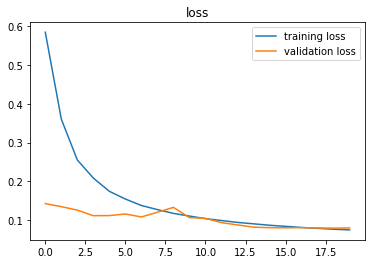

Plotting metrics...


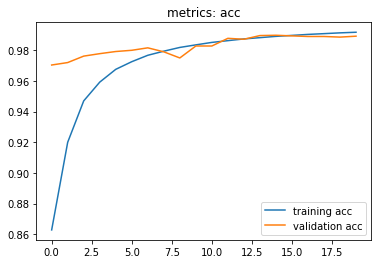

train {'acc': 1.0}
test {'acc': 0.9865}

Training student with temperature = 8 , coef = 1 .
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14393183231245821605
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3112632320
locality {
  bus_id: 1
}
incarnation: 14541035351542179820
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1"
]
Epoch 1 , step 0 , loss= 4.332691 , acc = 0.5 
t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.03914399999996476
loss_train : 0.03447799999992185
metric batch : 0.018489000000045053
whole : 0.09242799999992712
display_whole : 0.05326700000000528
Epoch 1 , step 100 , loss= 2.5784488 , acc = 0.94 
t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.004083000000036918
loss_train : 0.0022850000000289583
metric batch : 0.002333000000021457
whole : 0.009016999999971631
display_whole : 0.004923000000076172
Epoch 1 ,

Epoch 5 , step 100 , loss= 2.3279269 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 3.999999989900971e-06
train_op : 0.003349999999954889
loss_train : 0.0027460000000019136
metric batch : 0.0018939999999929569
whole : 0.008384999999975662
display_whole : 0.005029000000035921
Epoch 5 , step 200 , loss= 2.316437 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 4.9999999873762135e-06
train_op : 0.00342200000000048
loss_train : 0.002590000000054715
metric batch : 0.0017289999999547945
whole : 0.008160999999972773
display_whole : 0.0047319999999899665
Epoch 5 , step 300 , loss= 2.3093724 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 6.000000098538294e-06
train_op : 0.003746999999975742
loss_train : 0.002605000000016844
metric batch : 0.0017489999999042993
whole : 0.00849700000003395
display_whole : 0.004740999999967244
Epoch 5 , step 400 , loss= 2.3273969 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.004185000000006767
loss_train : 0.002624999999966348

Epoch 9 , step 300 , loss= 2.2956536 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 6.999999982326699e-06
train_op : 0.0037619999999378706
loss_train : 0.009634000000005472
metric batch : 0.00978999999995267
whole : 0.02353199999993194
display_whole : 0.01975799999991068
Epoch 9 , step 400 , loss= 2.3127804 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.999999979801942e-06
train_op : 0.0038189999999076463
loss_train : 0.011017999999921813
metric batch : 0.0019009999999752836
whole : 0.017129000000068118
display_whole : 0.013293999999973494
Epoch 9 , step 500 , loss= 2.3078208 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 6.999999982326699e-06
train_op : 0.00666599999999562
loss_train : 0.002721999999948821
metric batch : 0.0017670000000862274
whole : 0.01160400000003392
display_whole : 0.00492199999996501
Epoch 9 , step 549 , loss= 2.3017144 val_loss= 2.3642154 , acc = 1.0 val acc = 0.9834 
Epoch 9 finished, loss= 2.373573 t_cost <class 'dict'> 
get_batch : 4.9999999873762135e-06

Epoch 13 , step 500 , loss= 2.2953997 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 6.999999982326699e-06
train_op : 0.004312000000027183
loss_train : 0.0059489999999868814
metric batch : 0.0018029999999953361
whole : 0.012534999999957108
display_whole : 0.008210999999960222
Epoch 13 , step 549 , loss= 2.3003397 val_loss= 2.3525834 , acc = 1.0 val acc = 0.9858 
Epoch 13 finished, loss= 2.3546312 t_cost <class 'dict'> 
get_batch : 6.999999982326699e-06
train_op : 0.01215599999989081
loss_train : 0.008494999999925312
loss_val : 0.026136000000064996
metric_val : 0.025589999999965585
metric batch : 0.004143999999996595
whole : 0.07734400000003916
display_whole : 0.06517299999995885
Epoch 14 , step 50 , loss= 2.2989266 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 6.000000098538294e-06
train_op : 0.011942999999973836
loss_train : 0.020871000000056483
metric batch : 0.003706000000079257
whole : 0.036904000000049564
display_whole : 0.024946999999997388
Epoch 14 , step 150 , loss= 2.307509

In [ ]:

temperatures = [2,4,8,16,32,64]
train_metrics = {}
test_metrics = {}
for temperature in temperatures:
    # initialize metrics
    train_metrics[temperature] = []
    test_metrics[temperature] = []
    # prepare softened data
    y_train_soft = teacher.predict_softened(X_train, temperature)
    y_val_soft = teacher.predict_softened(X_val, temperature)
    y_test_soft = teacher.predict_softened(X_test, temperature)
    for coef_softloss in [1/(temperature**2), 1, temperature**2]:
        print('Training student with temperature =',temperature,', coef =',coef_softloss,'.')
        # build network architecture
        student = build_small_model(input_dims, output_dims, session, is_student=True)
        # train network
        student.soft_train(
            X=X_train
            ,y=y_train
            ,y_soft=y_train_soft
            ,temperature=temperature
            ,coef_softloss= coef_softloss# * temperature**2
            ,val_set=[X_val,y_val,y_val_soft]
            ,batch_size=100
            ,n_epochs=20
            ,display_steps=100)
        # show result
        print('Student performance with temperature =',temperature,', coef =',coef_softloss,'.')
        student.plt_loss()
        student.plt_metrics()
        train_metric = student.get_metrics(X_train, y_train)
        test_metric = student.get_metrics(X_test, y_test)
        print('train',train_metric)
        print('test',test_metric)
        print()
        train_metrics[temperature].append(train_metric)
        test_metrics[temperature].append(test_metric)
        gc.collect()

In [ ]:
print(test_metrics)

In [ ]:
# plot and show sample # deprecated
if try_cls2 and True:
    n_samples = 6
    round_show = 4
    n_data = X_test.shape[0]
    indices = np.random.choice(n_data,n_samples)
    for i in range(n_samples):
        sample = X_test[[indices[i]]]
        label = y_test[indices[i]]
        plt.imshow(sample.reshape((28,28)), cmap='gray')
        plt.show()
        pred = student.predict(sample)
        pred_t = student.predict_softened(sample, temperature=temperature)
        print(label)
        print(np.round(pred,round_show))
        print(np.round(pred_t,round_show))
#         print(np.round(pred_t2,round_show))
        #     student.predict()

In [ ]:
# close_session(session)